In [1]:
import pandas as pd
import numpy as np
import iris
import iris.quickplot as qplt
import cartopy.crs as ccrs

from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten, Lambda
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model, Sequence
from keras.optimizers import Adam, RMSprop
from keras import backend as K

from cartopy.util import add_cyclic_point

from sklearn import preprocessing
import os

import matplotlib.pyplot as plt
%matplotlib inline

WEIGHTS_CACHE = 'vae_conv_emulator.h5'

# os.environ["CUDA_VISIBLE_DEVICES"] = "1,2,3,4,5,6,7"

Using TensorFlow backend.


In [24]:
class IrisSequence(Sequence):

    def __init__(self, x_set, y_set, batch_size=1):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        res = batch_x, add_cyclic_point(batch_y.data)
        return res

def validation_plots(model, n_jobs, month=None):
    month = month or slice(None)
    # Create a copy of the zeroth job cube, predict the first test cube and then pop off the job dimension again
    pred=cube[:n_jobs,].copy(decoder.predict(X_TEST[:n_jobs,...])[..., :-1]) * (forcing_max - forcing_min) + forcing_min

    for job in range(n_jobs):
        fig = plt.figure(figsize=(12, 5))
        plt.subplot(121)
        qplt.pcolormesh(pred[job, month,...].collapsed('t', iris.analysis.MEAN), vmin=-10., vmax=10., cmap='RdBu_r')
        plt.gca().set_title("Predicted ({:.2f})".format(pred[job, month, ...].collapsed(pred.coords(), iris.analysis.MEAN).data))
        plt.gca().coastlines()

        ax = plt.subplot(122)
        t = (test_cube * (forcing_max - forcing_min) + forcing_min)[job, month, ...]
        qplt.pcolormesh(t.collapsed('t', iris.analysis.MEAN), vmin=-10., vmax=10., cmap='RdBu_r')
        plt.gca().set_title("Truth ({:.2f})".format(t.collapsed(pred.coords(), iris.analysis.MEAN).data))
        plt.gca().coastlines()

def fit_and_validate(model, n_plots=0, month=None):
    month = month or slice(None)
    model.fit_generator(IrisSequence(X, train_cube[...], batch_size), epochs=epochs,
                          validation_data=IrisSequence(X_TEST, test_cube[...], 1))
    if n_plots > 0:
        validation_plots(model, n_plots, month)
        
    pred=rescale(model.predict(X_TEST)[:,month,:, :-1])
    mse = (pred - rescale(test_cube.data))**2
    rmse_per_val=pd.DataFrame(np.sqrt(mse.mean(axis=(1,2,3))))
    print(rmse_per_val.describe())
    return rmse_per_val

In [5]:
project_path = "/home/ubuntu/A-CURE-project"
unit_path = project_path + "/PPE_Unit.csv"

N_PARAMS = 26
N_TEST = 183

if os.path.isfile(unit_path):
    all_data = pd.read_csv(unit_path, index_col=0)
    coordinate_cols = all_data.columns[:N_PARAMS]
else:
    all_data = pd.read_csv(project_path + "/data/PPE.csv", index_col=0)
    
    coordinate_cols = all_data.columns[:N_PARAMS]
    all_data[coordinate_cols] = preprocessing.scale(all_data[coordinate_cols])

    all_data.to_csv(project_path + "/data/PPE_Unit.csv")
    

# latent_cols = all_data.columns[26:]
latent_cols = all_data.columns[N_PARAMS:N_PARAMS+1]

# train, test = train_test_split(all_data, test_size=0.2)
train = all_data[:N_TEST]
test = all_data[N_TEST+1:]

X = train[coordinate_cols].values
Y = train[latent_cols].values

X_TEST = test[coordinate_cols].values
Y_TEST = test[latent_cols].values

In [6]:
def load_callback(cube, field, fname):
    cube.attributes = None
#     cube.attributes
    cube.add_dim_coord(iris.coords.DimCoord(np.arange(235), var_name='job'), (0,))

# Load a single merged cube for psuedo_level=2
cube = iris.util.squeeze(iris.load(project_path+"/data/ACI_pm2008???_N48.nc", callback=load_callback).concatenate_cube())

# Whiten the forcing
forcing_std_dev = np.std(cube.data, axis=(1,2,3), keepdims=True)
forcing_mean = np.mean(cube.data, axis=(1,2,3), keepdims=True)
normalised_input = (cube.data - forcing_mean) / forcing_std_dev

# Normalise the forcing
# forcing_min = np.min(cube.data, axis=(1,2,3), keepdims=True)
# forcing_max = np.max(cube.data, axis=(1,2,3), keepdims=True)
forcing_min = np.min(cube.data, axis=0, keepdims=True)
forcing_max = np.max(cube.data, axis=0, keepdims=True)

def scale(arr):
    return (arr - forcing_min) / (forcing_max - forcing_min)

def rescale(arr):
    return arr * (forcing_max - forcing_min) + forcing_min

normal_cube = cube.copy(data=scale(cube.data))

print(normal_cube)

# train, test = train_test_split(all_data, test_size=0.2)
train_cube = normal_cube[:N_TEST]
test_cube = normal_cube[N_TEST+1:]

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1932: UserWarning: Ignoring netCDF variable 'hybrid_ht_1' invalid units 'level'
  warnings.warn(msg)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1932: UserWarning: Ignoring netCDF variable 'hybrid_ht_1' invalid units 'level'
  warnings.warn(msg)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1932: UserWarning: Ignoring netCDF variable 'hybrid_ht_1' invalid units 'level'
  warnings.warn(msg)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1932: UserWarning: Ignoring netCDF variable 'hybrid_ht_1' invalid units 'level'
  warnings.warn(msg)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/i

Aerosol-Cloud Interactions / (1)    (job: 235; t: 12; latitude: 73; longitude: 96)
     Dimension coordinates:
          job                           x       -             -              -
          t                             -       x             -              -
          latitude                      -       -             x              -
          longitude                     -       -             -              x
     Scalar coordinates:
          Hybrid height: 87949.99


In [7]:
# network parameters
input_shape = (12, 73, 97)
batch_size = 8
kernel_size = (2, 3)
filters = 12
latent_dim = N_PARAMS
epochs = 30

learning_rate=1e-5
decay_rate=0.01

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
params (InputLayer)          (None, 26)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 21243)             573561    
_________________________________________________________________
reshape_1 (Reshape)          (None, 3, 73, 97)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 6, 73, 97)         114       
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 12, 73, 97)        444       
Total params: 574,119
Trainable params: 574,119
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Epoch 1/30
23/23

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 't'.
  warnings.warn(msg.format(self.name()))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/iris/coords.py:1138: UserWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/iris/coords.py:1138: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/iris/cube.py:3180: UserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(msg.format(coord.name()))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous

               0
count  51.000000
mean    1.160477
std     0.338230
min     0.864274
25%     1.025584
50%     1.082814
75%     1.195094
max     3.218006


0
0   0.913340
1   1.089806
2   1.014092
3   1.066672
4   1.253952
5   1.170016
6   1.082814
7   1.051300
8   1.310367
9   1.195729
10  1.027587
11  0.963423
12  1.296813
13  1.168577
14  1.352422
15  1.050086
16  1.592608
17  1.023580
18  0.991671
19  1.065855
20  1.525629
21  1.042628
22  0.929662
23  1.361454
24  1.097356
25  1.156708
26  1.152043
27  1.074666
28  0.925972
29  0.877484
30  1.062942
31  1.300450
32  0.941560
33  1.194460
34  1.131362
35  1.118735
36  1.002027
37  1.099628
38  1.475369
39  1.043429
40  1.450723
41  1.041260
42  3.218006
43  1.174749
44  1.255756
45  1.109945
46  0.864274
47  0.886745
48  1.030156
49  1.039155
50  0.919291

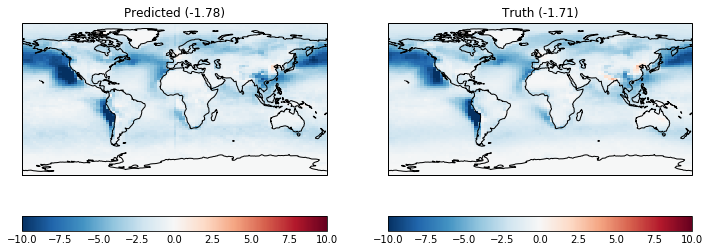

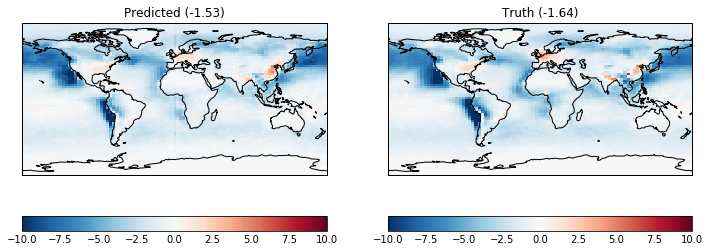

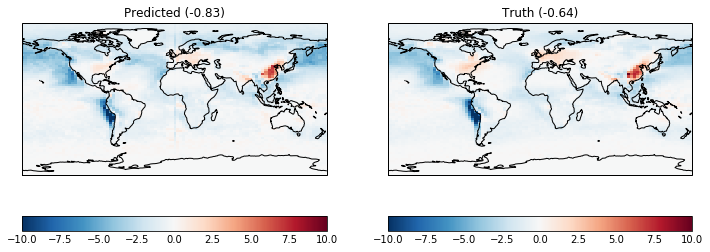

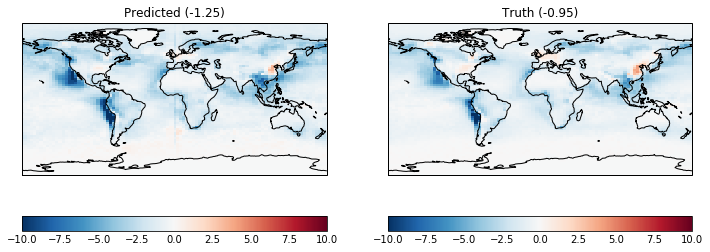

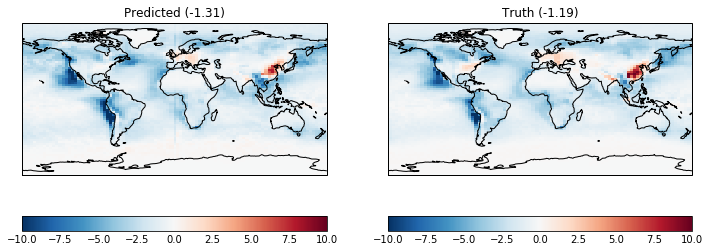

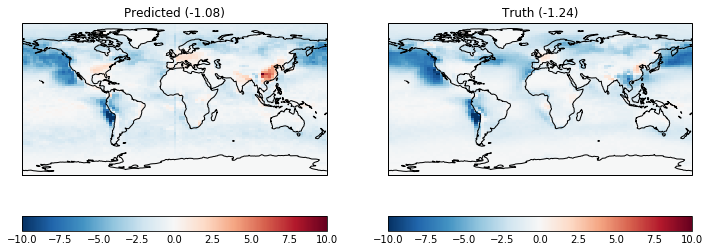

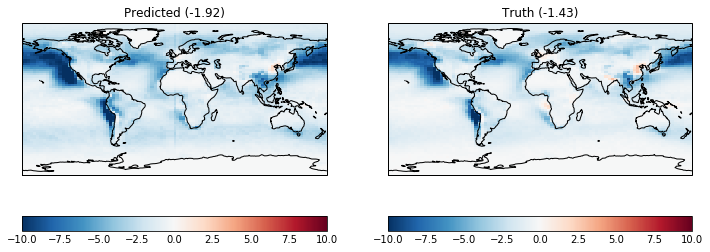

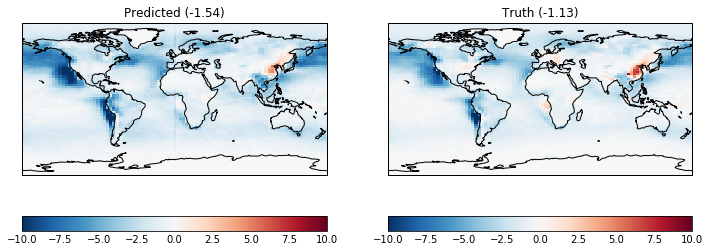

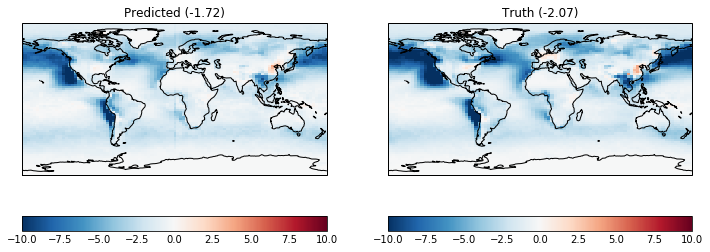

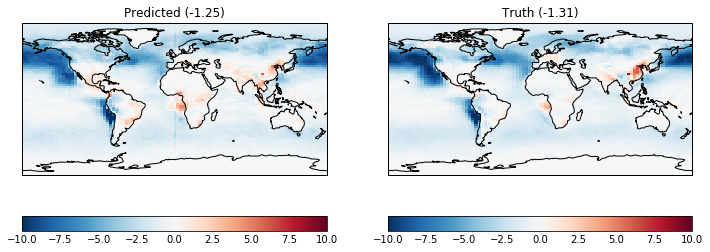

In [8]:
# build decoder model
latent_inputs = Input(shape=(N_PARAMS,), name='params')

shape = (None, 3, (73//1), (97//1))


x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

x = Conv2DTranspose(filters=6, input_shape=(12, 73, 97),
                    kernel_size=kernel_size,
                    activation='relu',
                    strides=1,
                    padding='same', data_format='channels_first')(x)

outputs = Conv2DTranspose(filters=filters, input_shape=(12, 73, 97),
                    kernel_size=kernel_size,
                    activation='relu',
                    strides=1,
                    padding='same', data_format='channels_first')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')

# decoder.compile(optimizer=Adam(lr=learning_rate, decay=decay_rate), loss='binary_crossentropy')
# decoder.compile(optimizer=RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.01), loss='binary_crossentropy')
decoder.compile(optimizer=RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.01), loss='mean_absolute_error')
decoder.summary()

fit_and_validate(decoder, n_plots=10)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
params (InputLayer)          (None, 26)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 21243)             573561    
_________________________________________________________________
reshape_4 (Reshape)          (None, 3, 73, 97)         0         
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 6, 73, 97)         114       
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 12, 73, 97)        444       
Total params: 574,119
Trainable params: 574,119
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
23/23 [==============================] - 1s 40ms/step - loss: 2.5118 - val_loss: 1.8409
Epoch 2/30
23/23 [===================

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 't'.
  warnings.warn(msg.format(self.name()))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/iris/coords.py:1138: UserWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/iris/coords.py:1138: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/iris/cube.py:3180: UserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(msg.format(coord.name()))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous

               0
count  51.000000
mean    1.193888
std     0.313920
min     0.874418
25%     1.042816
50%     1.102953
75%     1.239602
max     3.018378


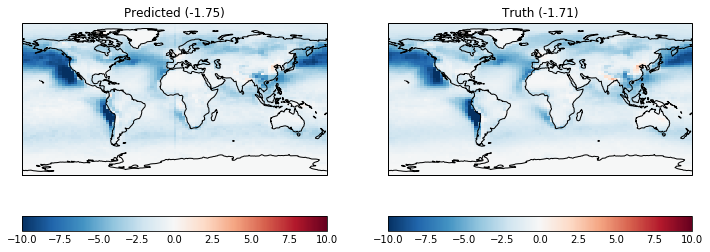

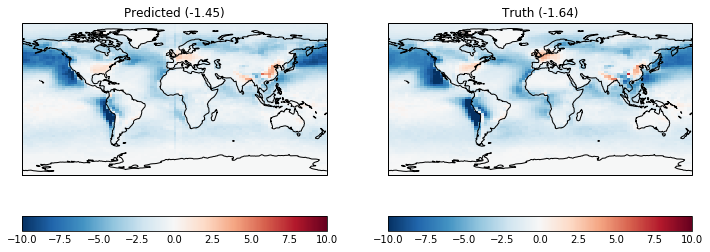

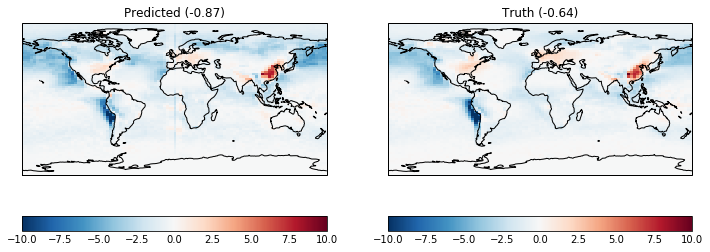

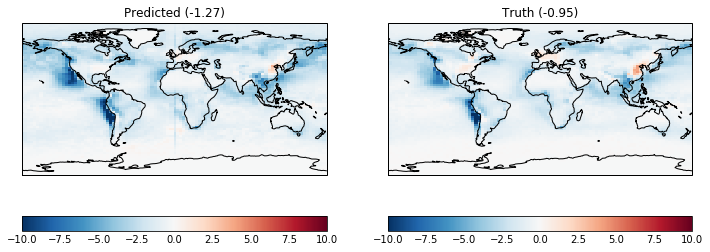

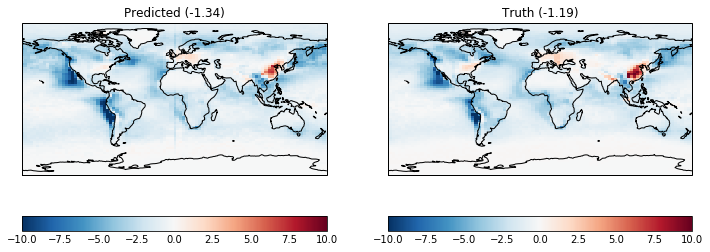

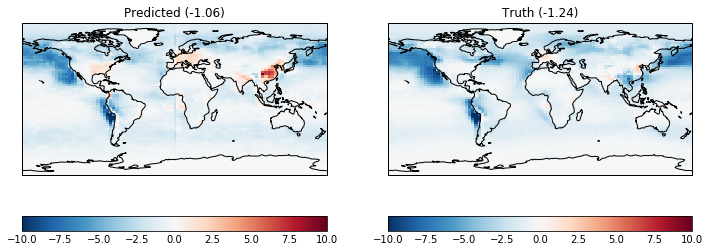

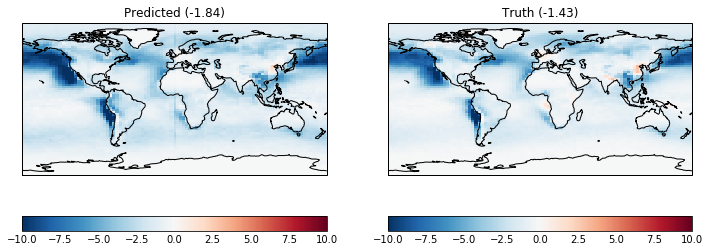

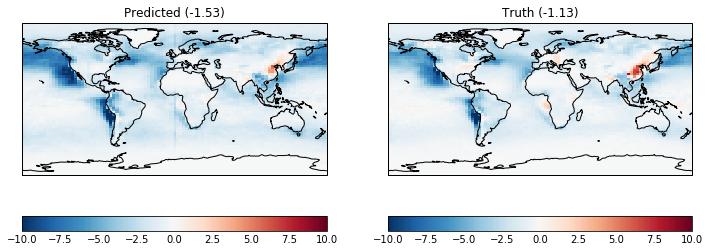

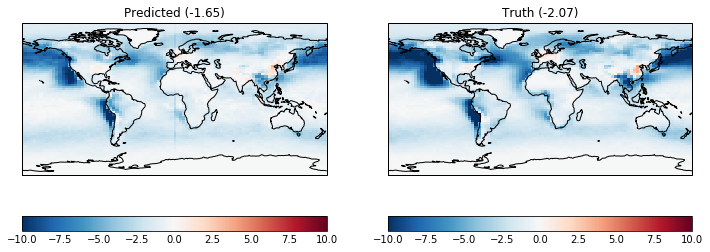

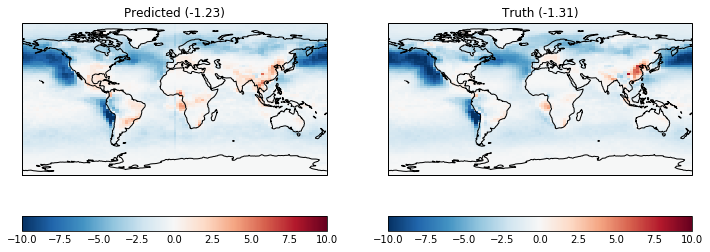

In [9]:
# build decoder model
latent_inputs = Input(shape=(N_PARAMS,), name='params')

shape = (None, 3, (73//1), (97//1))


x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

x = Conv2DTranspose(filters=6, input_shape=(12, 73, 97),
                    kernel_size=kernel_size,
                    activation='relu',
                    strides=1,
                    padding='same', data_format='channels_first')(x)

outputs = Conv2DTranspose(filters=filters, input_shape=(12, 73, 97),
                    kernel_size=kernel_size,
                    activation='relu',
                    strides=1,
                    padding='same', data_format='channels_first')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')

decoder.compile(optimizer=RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.01), loss='binary_crossentropy')
decoder.summary()

_ = fit_and_validate(decoder, n_plots=10)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
params (InputLayer)          (None, 26)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 21243)             573561    
_________________________________________________________________
reshape_2 (Reshape)          (None, 3, 73, 97)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 6, 73, 97)         114       
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 12, 73, 97)        444       
Total params: 574,119
Trainable params: 574,119
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
23/23 [==============================] - 1s 48ms/step - loss: 0.6928 - val_loss: 0.6919
Epoch 2/30
23/23 [===================

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 't'.
  warnings.warn(msg.format(self.name()))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/iris/coords.py:1138: UserWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/iris/coords.py:1138: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/iris/cube.py:3180: UserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(msg.format(coord.name()))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous

               0
count  51.000000
mean    1.047575
std     0.283897
min     0.712817
25%     0.845057
50%     0.995311
75%     1.120435
max     2.181808


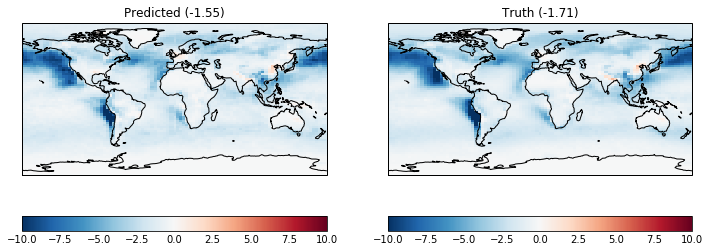

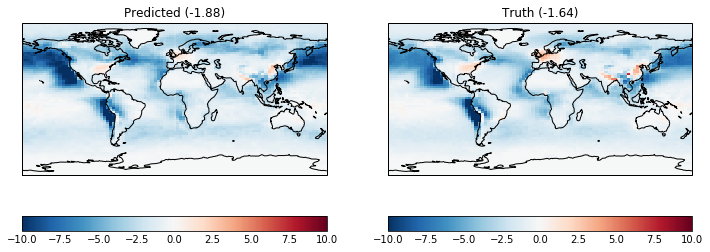

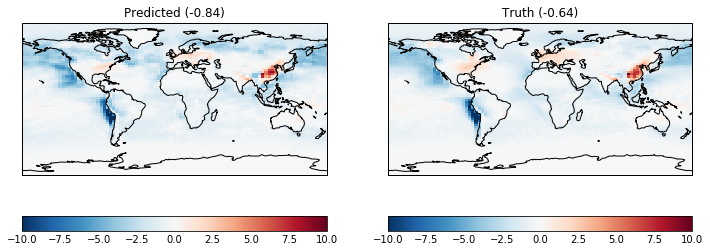

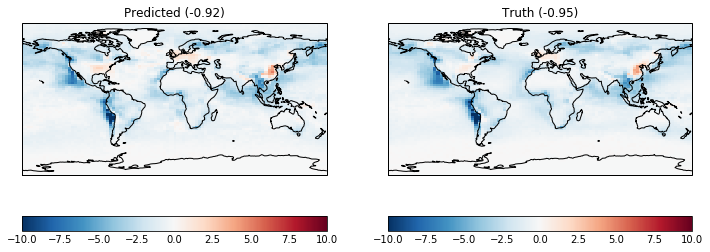

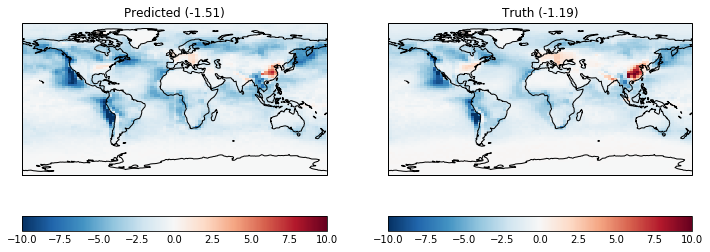

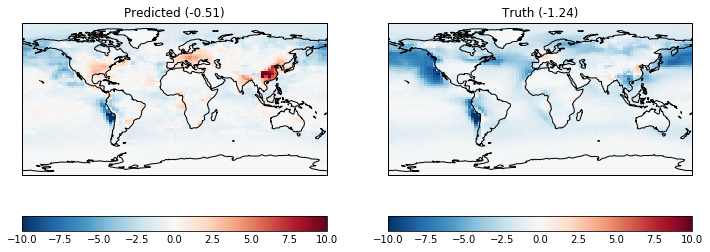

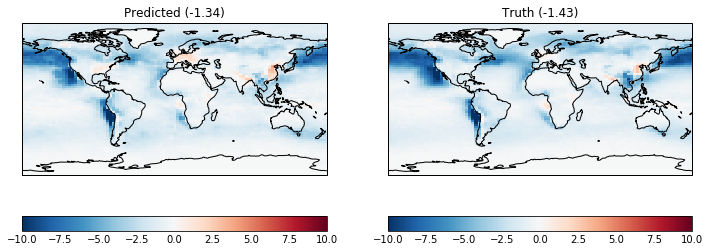

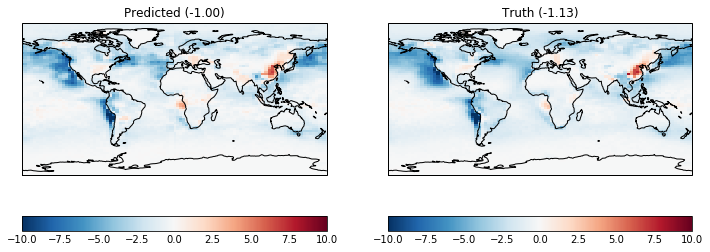

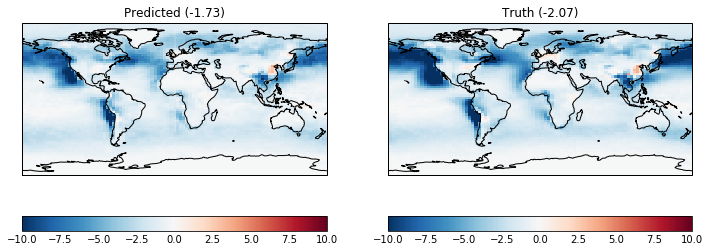

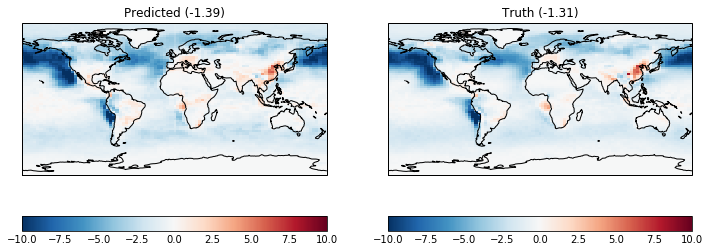

In [7]:
# build decoder model
latent_inputs = Input(shape=(N_PARAMS,), name='params')

shape = (None, 3, (73//1), (97//1))


x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

x = Conv2DTranspose(filters=6, input_shape=(12, 73, 97),
                    kernel_size=kernel_size,
                    activation='relu',
                    strides=1,
                    padding='same', data_format='channels_first')(x)

outputs = Conv2DTranspose(filters=filters, input_shape=(12, 73, 97),
                    kernel_size=kernel_size,
                    activation='sigmoid',
                    strides=1,
                    padding='same', data_format='channels_first')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')

decoder.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy')
decoder.summary()

_ = fit_and_validate(decoder, n_plots=10)

# July stats

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
params (InputLayer)          (None, 26)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 21243)             573561    
_________________________________________________________________
reshape_12 (Reshape)         (None, 3, 73, 97)         0         
_________________________________________________________________
conv2d_transpose_23 (Conv2DT (None, 6, 73, 97)         114       
_________________________________________________________________
conv2d_transpose_24 (Conv2DT (None, 12, 73, 97)        444       
Total params: 574,119
Trainable params: 574,119
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
23/23 [==============================] - 1s 55ms/step - loss: 0.6922 - val_loss: 0.6911
Epoch 2/30
23/23 [===================

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for 't'.
  warnings.warn(msg.format(self.name()))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/iris/coords.py:1138: UserWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/iris/coords.py:1138: UserWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  'contiguous bounds.'.format(self.name()))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/iris/cube.py:3180: UserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(msg.format(coord.name()))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/iris/coords.py:1355: UserWarning: Collapsing a non-contiguous

               0
count  51.000000
mean    1.268374
std     0.321608
min     0.972267
25%     1.090062
50%     1.177814
75%     1.342807
max     2.800660


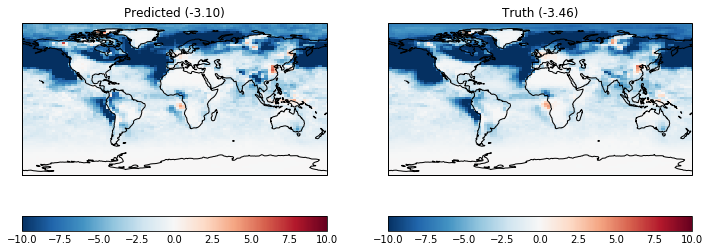

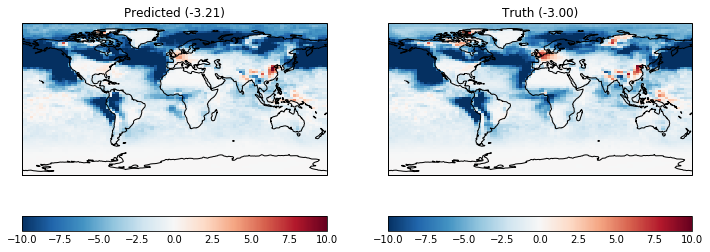

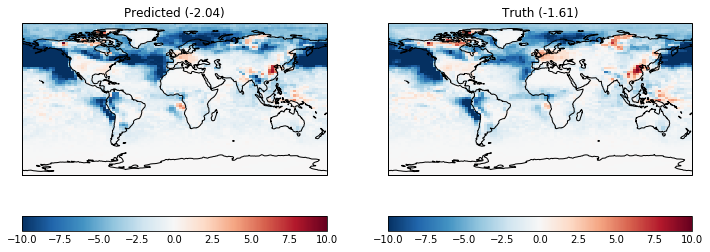

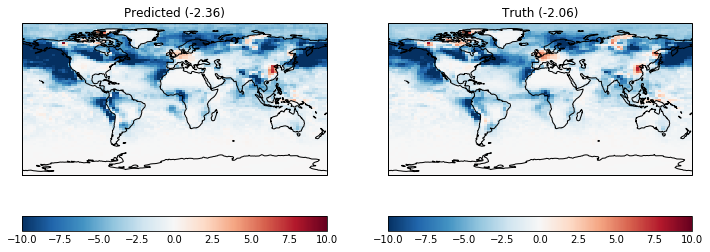

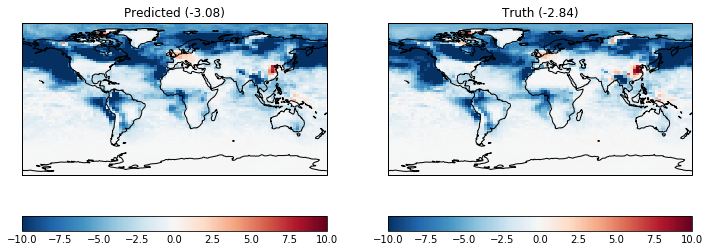

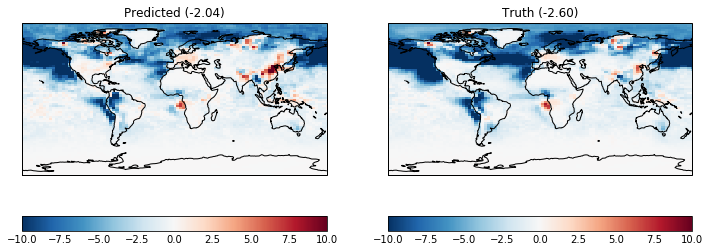

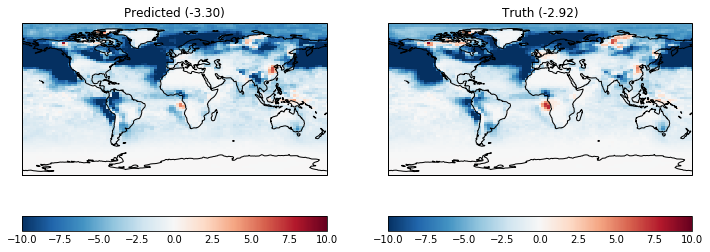

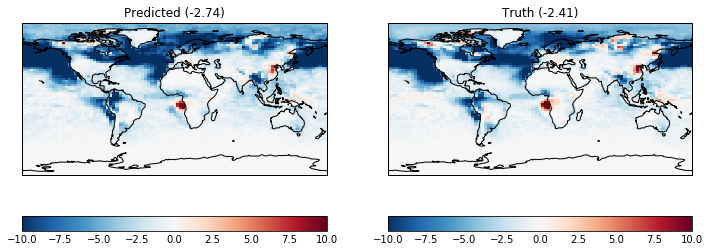

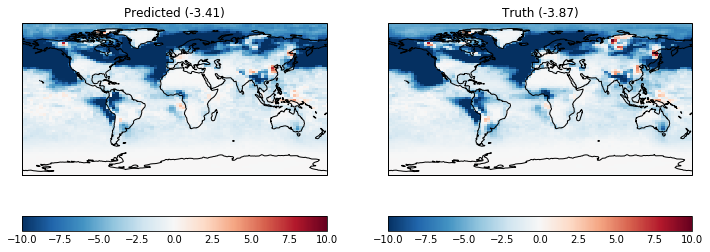

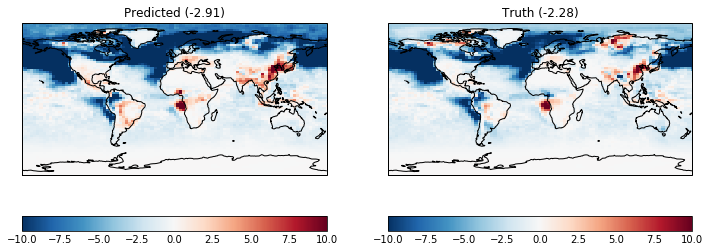

In [32]:
# build decoder model
latent_inputs = Input(shape=(N_PARAMS,), name='params')

shape = (None, 3, (73//1), (97//1))


x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

x = Conv2DTranspose(filters=6, input_shape=(12, 73, 97),
                    kernel_size=kernel_size,
                    activation='relu',
                    strides=1,
                    padding='same', data_format='channels_first')(x)

outputs = Conv2DTranspose(filters=filters, input_shape=(12, 73, 97),
                    kernel_size=kernel_size,
                    activation='sigmoid',
                    strides=1,
                    padding='same', data_format='channels_first')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')

decoder.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy')
decoder.summary()

_ = fit_and_validate(decoder, n_plots=10, month=slice(6, 7))